# Generate simulation data of several consecutive batchs

In [1]:
import casadi
import numpy as np
import pandas as pd
import os, sys
import pickle
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
mpl.rcParams["font.size"] = 9
mpl.rcParams["lines.linewidth"] = 3
mpl.rcParams["axes.grid"] = True

from column_variable_init_conds import template_model, template_simulator
from column_variable_init_conds import  update_u, update_x, update_z

In [26]:
trajectory = pd.read_pickle("./Data/alldata.pck")
index_array = np.arange(len(trajectory["Time"]))
# plt.plot(index_array,trajectory["Flowsheet.e0_HU_L_st9"].to_numpy())
batch_indexes = {"Batch 1":[3000,3224],      # [50,3000]
                 "Batch 2":[5900,6110],     # [3300,5900]
                 "Batch 3":[6008,8400],     # [6200,8400]
                 "Batch 4":[9000,12500],    # [9000,12500]
                 "Batch 5":[12000,14600],   # [12000,14600]
                 "Batch 6":[15000, 17600],  #[15000, 17600]
                 "Batch 7":[17900, 20000],  #[17900, 20000]
                 "Batch 8":[20500, 23000],  #[20500, 23000]
                 "Batch 9":[23350, 25800],  #[23350, 25800]
                 "Batch 10":[26300, 29500]} #[26300, 29500]

break_time_stamps = [3224,6008,8828,9000,11591,14702,17707,23163,25921,28884]

# 3224+30
# 6008
# 8828
# 9000
# 11591
# 14702
# 17707
# 23163
# 25921
# 28884

Set up the simulator

In [55]:
index_max = len(trajectory) - 1  # 28885
batch_limits = [2,2]
index0 = batch_indexes["Batch {}".format(batch_limits[0])][0]

model = template_model(init_ind=index0)
simulator = template_simulator(model,init_ind=index0)

params_simulator = {
    "integration_tool": "idas",
    "abstol": 1e-3,
    "reltol": 1e-3,
    "t_step": 1,
}
simulator.set_param(**params_simulator)
simulator.setup()
simulator.set_initial_guess()

In [56]:
first_batch = "Batch {}".format(batch_limits[0])
last_batch = "Batch {}".format(batch_limits[1])
step_num = batch_indexes[last_batch][1]-batch_indexes[first_batch][0]
print("Number of steps is {}\n".format(step_num))
t0 = index0 * params_simulator["t_step"] 

# Simulationsrechnung
trajectory_ts = trajectory["Time"].to_numpy()
batch_num = batch_limits[0]
u0 = simulator.u0.master
for step in range(step_num):
    reset_init_conds = False
    # check if each batch simulation is finished
    if (step > 1) and (simulator.data["_time"][-1][0]+index0 >= 
                       trajectory_ts[break_time_stamps[batch_num-1]]):
        batch_num += 1
        reset_init_conds =  True
    # if last batch achieved, beak simulation loop
    if (batch_num > batch_limits[-1]+1):
        break
    # if simulation goes on reset initial conditions
    elif reset_init_conds:
        # how should we reset the simulator????
        print("\nBatch switch encountered\n")
        batch_start_time = trajectory_ts[break_time_stamps[batch_num]+50]
        update_u(simulator,trajectory=-1,use_time=True,time=batch_start_time,getoutput=True)
        update_x(simulator,trajectory=-1,use_time=True,time=batch_start_time,getoutput=True)
        update_z(simulator,trajectory=-1,use_time=True,time=batch_start_time,getoutput=True)
        simulator.simulate()
        simulator.set_initial_guess()
#         simulator.make_step(u0)
        reset_init_conds = False
        print("States and algebraic states has been resetted\n")
    # normal computation step within each batch
    else:
        process_time = simulator.data["_time"][-1][0] if step > 0 else 0
        update_u(simulator,trajectory=-1,use_time=True,time=process_time+t0,getoutput=True)
        simulator.make_step(u0)
    # Display every 200th step to keep track of simulation progress
    if step%200 == 0:
        print(step)
        
print("\nSimulation is successfully finished !")

Number of steps is 210

0

Batch switch encountered

States and algebraic states has been resetted

200

Simulation is successfully finished !


In [36]:
step

209

In [49]:
break_time_stamps[batch_num+1]
batch_num
(step > 1) and (simulator.data["_time"][-1] >= 
                       trajectory_ts[break_time_stamps[batch_num]])
simulator.data["_time"][-1][0]+index0
trajectory_ts[break_time_stamps[batch_num]]
batch_num

2

In [122]:
a=simulator.x0["e0_HU_st0_i1"]
print(simulator.data["_x","e0_HU_st0_i1"][-1])
simulator.data["_x","e0_HU_st0_i1"][-1] = 0*np.array([9])
print(simulator.data["_x","e0_HU_st0_i1"][-1])
d = simulator.data
casadi.

[0.01975409]
[0.01975409]


In [144]:
type(a)
type(a.__float__())
d.update()
# d["_x","e0_HU_st0_i1"] = np.zeros(d["_x","e0_HU_st0_i1"].shape)
simulator.x0["e0_HU_st0_i1",-1] = casadi.DM(0)
print(simulator.x0["e0_HU_st0_i1"])

0


In [139]:
casadi.DM(0)

DM(0)

In [21]:
def compare_plots(simulator,trajectory,t0,var_dict:dict,index=0):
    i = 100
    
    for var_type, variables in var_dict.items():
        if var_type.lower() == "z":
            spec = "_z"
            color = "b"
        elif var_type.lower() == "u":
            spec = "_u"
            color = "k"
        elif var_type.lower() == "x":
            spec = "_x"
            color = "b"
        
        ind0, ind_end = index0, batch_indexes["Batch {}".format(batch_limits[-1])][-1]+50
        for var_name in variables:
            i +=1
            plt.figure(num=i)
            plt.plot(simulator.data["_time"]+t0,simulator.data[spec,var_name],"{}o-".format(color),label="model")
            plt.plot(trajectory["Time"][ind0:ind_end],trajectory["Flowsheet."+var_name][ind0:ind_end],"y",label="data")
            plt.legend()
            plt.xlabel("Time in seconds")
            plt.title(var_name)

In [100]:
ind0, ind_end = index0, batch_indexes["Batch {}".format(batch_limits[-1])][-1]
print(ind0, ind_end)

5800 6008


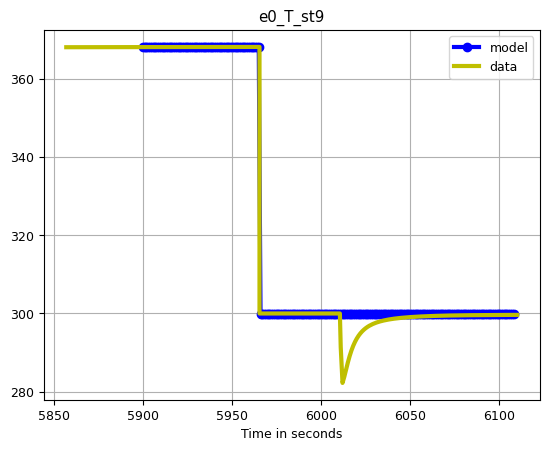

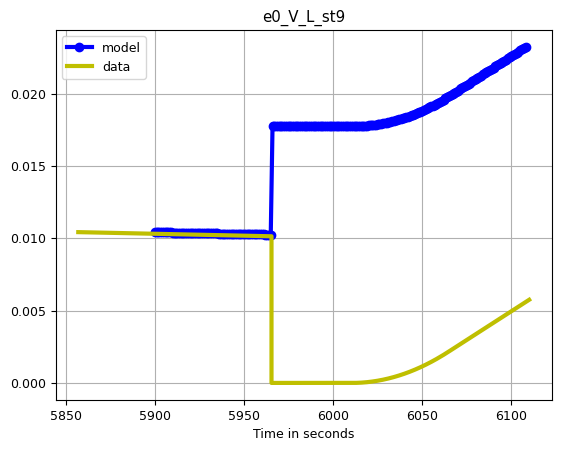

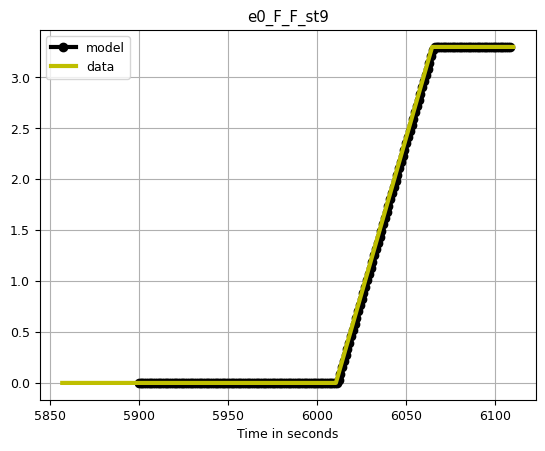

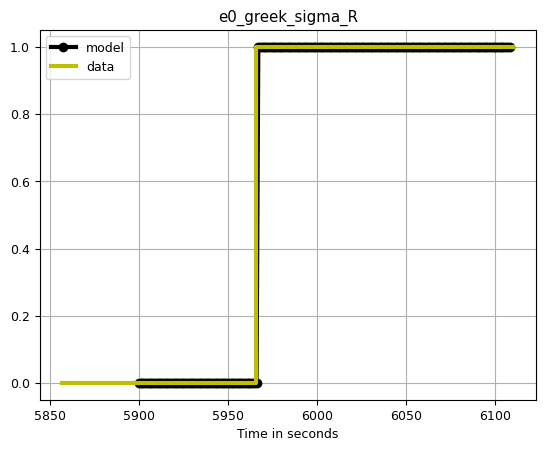

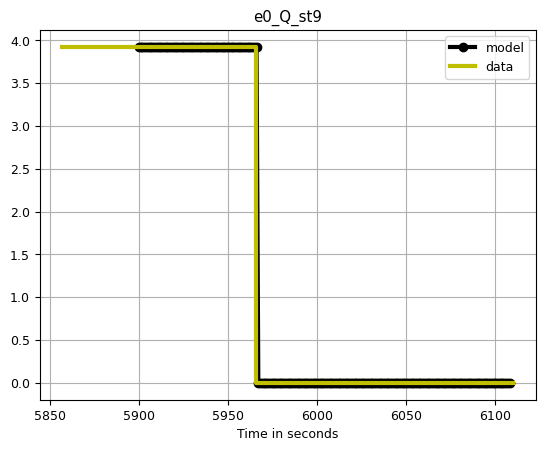

In [57]:
var_dict = {"x":[],"z":["e0_T_st9","e0_V_L_st9"],"u":["e0_F_F_st9","e0_greek_sigma_R","e0_Q_st9"]}
compare_plots(simulator,trajectory,t0,var_dict,index=index0)

In [23]:
print(simulator.data["_z","e0_V_L_st9"][0], trajectory["Flowsheet.e0_V_L_st9"].iloc[index0], sep="\n")

[0.01042339]
0.010423389582294822
